In [1]:
import game as gm
import numpy as np
from scipy.optimize import root
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import statsmodels.api as sm
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

from IPython.display import clear_output

In [2]:
def filter_data(arr: list | np.ndarray, threshold = 2) -> np.ndarray:
	# filter data: pick not `None`
	mask1 = [True if x is not None else False for x in arr]

	# filter data: drop outliers by `resid`
	# 1. Fit arr with linear model: arr_i = b_0 + b_1 * i + b_2 * i^2 + resid
	arridxs = list(range(len(arr)))
	X = np.column_stack((arridxs, [x**2 for x in arridxs]))
	X = sm.add_constant(X)
	model = sm.OLS(np.array(arr)[mask1], X[mask1, :])
	results = model.fit()

	# 2. Calculate the std. error of `resid`
	fit_resids = results.resid
	std = np.std(fit_resids)

	# 3. Drop outlier
	mask2 = [
		True if x is not None and
			- threshold * std <=
				abs(x - results.predict([1, idx, idx**2])) <=
					threshold * std
		else False
		for x, idx in zip(arr, arridxs)
	]

	# 4. fit the model without outlier again
	interp_y = np.array(arr)[mask2]
	interp_x = np.array(arridxs)[mask2]
	f = interp1d(interp_x, interp_y, kind='linear', fill_value='extrapolate')
	arr_new = f(arridxs)
	return arr_new

In [3]:
test_arr = [None, 2, 3, 4, None, 10, 7, None, 9, 10, None]
test_arr = filter_data(test_arr)
test_arr = filter_data(test_arr)
test_arr

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [4]:
game = gm.Game2(n=5, r=0.6, M1=0.5, M2=1.0, sigma1=1, sigma2=1)
gamma1 = 1. / 4.
gamma2 = 1. / 4.

#### (1) $r>1/2$, $M_1 < M_2$, smaller market moves first

There isn't first-mover advantage

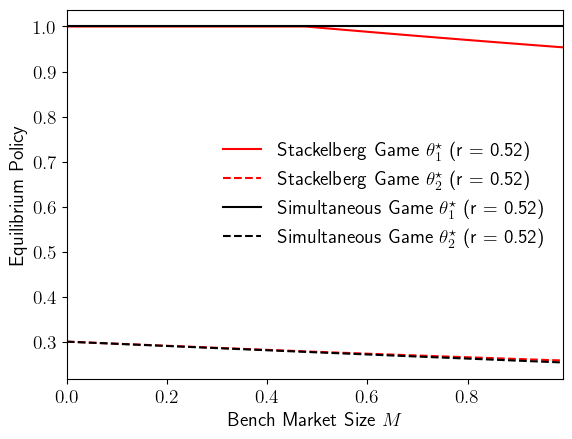

In [5]:
r_big = 0.52
gamma = 0.2

arr_M = []

arr_theta1_simul = []
arr_theta2_simul = []
arr_d1_simul = []
arr_d2_simul = []
arr_Phi1_simul = []
arr_Phi2_simul = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.0 + ii / 100
	# define game
	game_M = gm.Game2(n=5, r=r_big, M1=M/2, M2=M, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = gm.simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = gm.stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_simul, theta2_simul = theta_stars
		d1_simul, d2_simul = game.equilibrium(theta1_simul, theta2_simul)
		Pi1_simul = gm.government_obj(game.r, d1_simul, d2_simul, theta1_simul, theta2_simul, gamma)
		Pi2_simul = gm.government_obj(game.r, d2_simul, d1_simul, theta2_simul, theta1_simul, gamma)
		arr_theta1_simul.append(theta1_simul)
		arr_theta2_simul.append(theta2_simul)
		arr_d1_simul.append(d1_simul)
		arr_d2_simul.append(d2_simul)
		arr_Phi1_simul.append(Pi1_simul)
		arr_Phi2_simul.append(Pi2_simul)
	else:
		arr_theta1_simul.append(None)
		arr_theta2_simul.append(None)
		arr_d1_simul.append(None)
		arr_d2_simul.append(None)
		arr_Phi1_simul.append(None)
		arr_Phi2_simul.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = gm.government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = gm.government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_simul),
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta_1^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_simul),
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\theta_2^\star$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_cmpeq_simul_seq_r52_small1st.pdf', bbox_inches='tight')
plt.show()

#
fig = plt.gcf()
w, h = fig.get_size_inches()
fig.set_size_inches(w, h * 2 / 3.5)
plt.xlim((arr_M[0], arr_M[-1]))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\Pi_1$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_simul)   ,
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\Pi_1$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='upper right')
plt.savefig('../_numerical_output/fig_asym_1stmoveradv_r52_small1st_1.pdf', bbox_inches='tight')
plt.show()

#
fig = plt.gcf()
w, h = fig.get_size_inches()
fig.set_size_inches(w, h * 2 / 3.5)
plt.xlim((arr_M[0], arr_M[-1]))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\Pi_2$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_simul)   ,
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\Pi_2$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_1stmoveradv_r52_small1st_2.pdf', bbox_inches='tight')
plt.show()

#### (2) $r>1/2$, $M_1 > M_2$, larger market moves first

There is first-mover advantage when $M$ is small, and first-mover disadvantage when $M$ is large. 

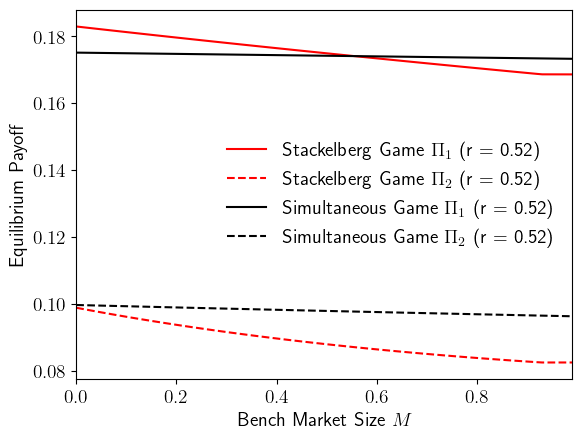

In [6]:
#
r_big = 0.52
gamma = 0.2

arr_M = []

arr_theta1_simul = []
arr_theta2_simul = []
arr_d1_simul = []
arr_d2_simul = []
arr_Phi1_simul = []
arr_Phi2_simul = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.0 + ii / 100
	# define game
	game_M = gm.Game2(n=5, r=r_big, M1=M, M2=M/2, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = gm.simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = gm.stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_simul, theta2_simul = theta_stars
		d1_simul, d2_simul = game.equilibrium(theta1_simul, theta2_simul)
		Pi1_simul = gm.government_obj(game.r, d1_simul, d2_simul, theta1_simul, theta2_simul, gamma)
		Pi2_simul = gm.government_obj(game.r, d2_simul, d1_simul, theta2_simul, theta1_simul, gamma)
		arr_theta1_simul.append(theta1_simul)
		arr_theta2_simul.append(theta2_simul)
		arr_d1_simul.append(d1_simul)
		arr_d2_simul.append(d2_simul)
		arr_Phi1_simul.append(Pi1_simul)
		arr_Phi2_simul.append(Pi2_simul)
	else:
		arr_theta1_simul.append(None)
		arr_theta2_simul.append(None)
		arr_d1_simul.append(None)
		arr_d2_simul.append(None)
		arr_Phi1_simul.append(None)
		arr_Phi2_simul.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = gm.government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = gm.government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.5, 0.9))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_simul)   ,
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta_1^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_simul)   ,
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\theta_2^\star$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_cmpeq_simul_seq_r52_large1st.pdf', bbox_inches='tight')
plt.show()

#
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.16, 0.23))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\Pi_1$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\Pi_2$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_simul)   ,
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\Pi_1$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_simul)   ,
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\Pi_2$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_1stmover_adv_r52_large1st.pdf', bbox_inches='tight')
plt.show()

#### (3) $r < 1/2$, $M_1 < M_2$, smaller market moves first

There is a few first-mover advantage

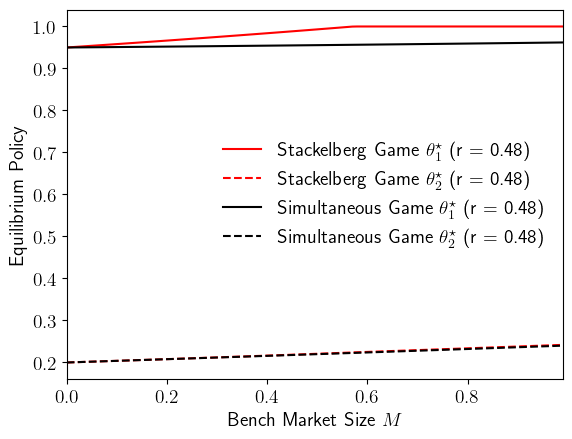

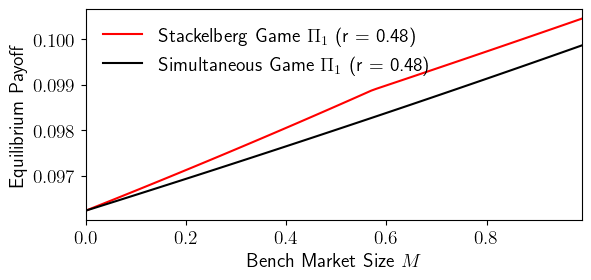

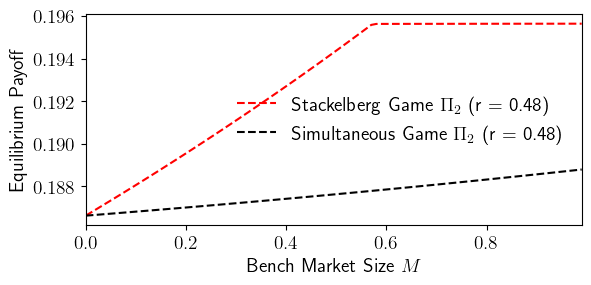

In [7]:
#
r_small = 0.48
gamma = 0.2

arr_M = []

arr_theta1_simul = []
arr_theta2_simul = []
arr_d1_simul = []
arr_d2_simul = []
arr_Phi1_simul = []
arr_Phi2_simul = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.0 + ii / 100
	# define game
	game_M = gm.Game2(n=5, r=r_small, M1=M/2, M2=M, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = gm.simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = gm.stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_simul, theta2_simul = theta_stars
		d1_simul, d2_simul = game.equilibrium(theta1_simul, theta2_simul)
		Pi1_simul = gm.government_obj(game.r, d1_simul, d2_simul, theta1_simul, theta2_simul, gamma)
		Pi2_simul = gm.government_obj(game.r, d2_simul, d1_simul, theta2_simul, theta1_simul, gamma)
		arr_theta1_simul.append(theta1_simul)
		arr_theta2_simul.append(theta2_simul)
		arr_d1_simul.append(d1_simul)
		arr_d2_simul.append(d2_simul)
		arr_Phi1_simul.append(Pi1_simul)
		arr_Phi2_simul.append(Pi2_simul)
	else:
		arr_theta1_simul.append(None)
		arr_theta2_simul.append(None)
		arr_d1_simul.append(None)
		arr_d2_simul.append(None)
		arr_Phi1_simul.append(None)
		arr_Phi2_simul.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = gm.government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = gm.government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_simul),
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta_1^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_simul),
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\theta_2^\star$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_cmpeq_simul_seq_r48_small1st.pdf', bbox_inches='tight')
plt.show()

#
fig = plt.gcf()
w, h = fig.get_size_inches()
fig.set_size_inches(w, h * 2 / 3.5)
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.19, 0.27))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\Pi_1$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_simul),
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\Pi_1$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_1stmoveradv_r48_small1st_1.pdf', bbox_inches='tight')
plt.show()

#
fig = plt.gcf()
w, h = fig.get_size_inches()
fig.set_size_inches(w, h * 2 / 3.5)
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.19, 0.27))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\Pi_2$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_simul),
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\Pi_2$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_1stmoveradv_r48_small1st_2.pdf', bbox_inches='tight')
plt.show()

#### (4) $r < 1/2$, $M_1 > M_2$, larger market moves first

There is first-mover advantage

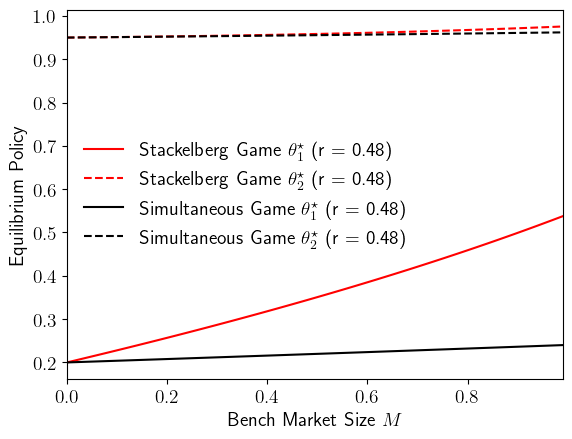

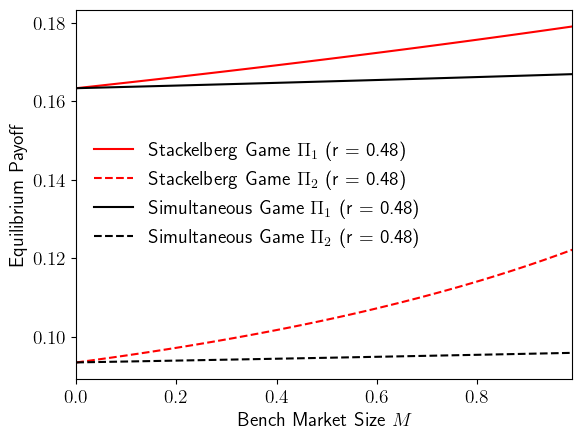

In [8]:
#
r_small = 0.48
gamma = 0.2

arr_M = []

arr_theta1_simul = []
arr_theta2_simul = []
arr_d1_simul = []
arr_d2_simul = []
arr_Phi1_simul = []
arr_Phi2_simul = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.0 + ii / 100
	# define game
	game_M = gm.Game2(n=5, r=r_small, M1=M, M2=M/2, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = gm.simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = gm.stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_simul, theta2_simul = theta_stars
		d1_simul, d2_simul = game.equilibrium(theta1_simul, theta2_simul)
		Pi1_simul = gm.government_obj(game.r, d1_simul, d2_simul, theta1_simul, theta2_simul, gamma)
		Pi2_simul = gm.government_obj(game.r, d2_simul, d1_simul, theta2_simul, theta1_simul, gamma)
		arr_theta1_simul.append(theta1_simul)
		arr_theta2_simul.append(theta2_simul)
		arr_d1_simul.append(d1_simul)
		arr_d2_simul.append(d2_simul)
		arr_Phi1_simul.append(Pi1_simul)
		arr_Phi2_simul.append(Pi2_simul)
	else:
		arr_theta1_simul.append(None)
		arr_theta2_simul.append(None)
		arr_d1_simul.append(None)
		arr_d2_simul.append(None)
		arr_Phi1_simul.append(None)
		arr_Phi2_simul.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = gm.government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = gm.government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.7, 1.00))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_simul),
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta_1^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_simul),
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\theta_2^\star$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_cmpeq_simul_seq_r48_large1st.pdf', bbox_inches='tight')
plt.show()

#
plt.xlim((arr_M[0], arr_M[-1]))
#plt.ylim((0.19, 0.27))
plt.xlabel(r'Bench Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='solid',
	color='red',
	label=fr'Stackelberg Game $\Pi_1$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='red',
	label=fr'Stackelberg Game $\Pi_2$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_simul),
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\Pi_1$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_simul),
	linestyle='dashed',
	color='black',
	label=fr'Simultaneous Game $\Pi_2$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_asym_1stmoveradv_r48_large1st.pdf', bbox_inches='tight')
plt.show()